# Penny Stock Model

In [272]:
# import libraries
import pandas as pd
import yfinance as yf
import numpy as np
import datetime
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
sns.set()


In [273]:
# parameters
VolRise = 0.99        # open position, after current volume will be more than VolRise value
AvgVolDayLimit = 10   # average for shifting average
ExitAfter = 0.25      # close position after price achieve ExitAfter
StopLoss = -0.07      # close position after price meets stop
RiskPertrade = 2000   # buy for sum 
TradeAfterDays = 3    # begin trade after TradeAfterDays days from start
price_filter = 0.5     # below this price we open pos
price_Stock_filter = 5  # above this price we don't load stock
high_prevClose = 0.1 # if high more than previous close on high_prevClose
UpperBandVol = 0.7      # if price is in range of  UpperBandVol and LowwerBandVol - please take a volume
LowwerBandVol = 0.09    #   if price is in range of  UpperBandVol and LowwerBandVol - please take a volume
positionValue = 10000   # the sum you need to collect
openPosStatus = False 
volume_potensial =0 
close_signal = 4       # 1 = 100% growth, 2 = growth to $1 price, 3 = hold position for 1 month, 4 = after achieving 100% growth, close when price falls below SMA5




In [274]:
# дата старту набору позиції
# дата закінчення набору позиції
class StockBalance():
    positionValue = 10000
   
    def __init__(self, ticker):
        self.ticker = ticker
        self.market_value = 0
        self.date_end_pos = 0 # last date when we collect stock
        self.qty = 0
        self.avg_price = 0
        self.volume_pot = 0
        self.need = positionValue
        

    
    def add(self,amount, price, posdate):
        self.qty += amount
        val=price*amount
        self.market_value += val
        self.avg_price = self.market_value/self.qty
        self.date_end_pos = posdate

    
    def is_full(self):
        return self.market_value >=StockBalance.positionValue
    
    def clear(self):
        self.qty = 0
        self.market_value = 0
        self.avg_price = 0
    
    def volume_potensial(self, high, low, close, volume):
        
        if abs(high-low)==0:
            self.volume_pot
        else:
            self.volume_pot = ((abs(close-low)/abs(high-low))*volume)*0.05
        if self.volume_pot == 0 :
            self.volume_pot = volume*0.05
        
    def isclosesignal(self, nom_of_sig, price, cur_date, smaprice):
        if self.market_value>0:  # if there is open position
            
            if nom_of_sig == 1:
                if (price > self.avg_price*2):
                    return True
            if nom_of_sig == 2:
                if self.avg_price>1:
                    return True
            if nom_of_sig == 3:
                if (cur_date-self.date_end_pos)> datetime.timedelta(20): 
                    return True
            if nom_of_sig == 4:
                if (price > self.avg_price*2) & (price < smaprice):
                    return True
        else:
            return False
      
    def stoptrade(self,curentdate,lastdate):
        
        if self.market_value>0:
            
        # check is it time to close position
            if (curentdate-datefromlist)>=datetime.timedelta(160):
                return True
        
            #if lastdate==curentdate: # if we reached last row
             #   return True
        
        
        

In [275]:
def good_price(ticker_name,date_from_list):
    
    # function to calculate appropriate price
    res = False
    stock_ticker = yf.Ticker(ticker_name)
    r = stock_ticker.history(max,"1d",date_from_list)
    price = r.iloc[0]["Close"]
    if price<price_Stock_filter:
        res = True

    return res


In [276]:
#reed.history("1mo","1d","2022-10-23","2023-01-10")


In [277]:
# load ticker list from excel-file
list_stocks = pd.read_excel('inputFiles/list_stocks.xlsx', index_col ='Company')
all_res = []
data_group=[]
data_group_res=[]

stock_res =[]
stock_small_res=[]
#len(list_stocks)

# here begin to iterate between stocks
for i in range(len(list_stocks)): # потім прописати весь список
    symbol = list_stocks.index[i] # беремо акцію по індексу

    datefromlist = list_stocks.iloc[i]['NotDate']
    #print('symbol=',symbol)
    #print('datefromlist=',datefromlist)
    
    # error it may be situation, when price is fall down 
    if good_price(symbol,datefromlist)==False: # if price meet conditions
        continue
    
    # this is blok where stock suit out coundition
    mystock = StockBalance(symbol)
    openPosStatus = False
    # to calc average volume use 20 days before
    start_date = datefromlist - datetime.timedelta(days=19)                                           
    end_date = datefromlist + datetime.timedelta(days=180)

    

    #load stock price
    #symbol = list_stocks.index[i] # беремо акцію по індексу
    wdf = yf.download(symbol, start_date, end_date)



    # building features in working dataframe
    wdf['avgvol']= wdf['Volume'].rolling(window=AvgVolDayLimit, win_type=None).mean()  # середній обєм за 10 днів
    wdf['VolRise'] =wdf['Volume']/wdf['avgvol']-1      # building vol signal
    wdf['SMA5']= wdf['Close'].rolling(5).mean()
    wdf['PrevClose'] = wdf.Close.shift(1)      # write previous close
    wdf['volsignal']=wdf['VolRise']>VolRise            # volume signal column
    wdf['GreenCandleSig'] = wdf['Close']>wdf['Open']   # green candle
    wdf['HighGrowPrevClose'] = (wdf["High"]/wdf['PrevClose']-1)> high_prevClose # high is bigger than previous low
    wdf['TradeAfter']=wdf.index
    wdf['TradeAfterDaysSig'] = wdf['TradeAfter'] > datefromlist + datetime.timedelta(days=TradeAfterDays)
    wdf['OpenPrice']=0
    wdf['openPosStatus']=False
    wdf['VolumePoten']=0
    wdf['MarketValue']=0
    wdf['AvgPrice']=0
    wdf['Profit']=0
    wdf['test']=""
    wdf['StopPrice']=0
    wdf['TargetPrice']=0
    wdf['Ticker']=symbol
    del(wdf['TradeAfter'])
    lastrow=wdf.tail(1).index # last row in order to stop calculations

    # main module
    PriceOpen = 0
    StopPrice = 0
    TPPrice = 0
    CloseSignal = 0
    status = 0
    
    
    for index, row in wdf.iterrows():  # change to itertuple....
        
        # calculate volume potential
        mystock.volume_potensial(row['High'],row['Low'],row['Close'],row['Volume'])
        wdf.at[index,'VolumePoten']= mystock.volume_pot    
        
        # looking for opening signal 
        if (mystock.market_value ==0) & ((index-datefromlist)<=datetime.timedelta(150)): #  if we haven't opened position and we have 150 days 
            
            if row['volsignal'] & row['TradeAfterDaysSig'] & row['GreenCandleSig'] & row['HighGrowPrevClose']:  # if Volume > than AvgVolume and green candle and high more then 
                if row["Close"]>price_filter: # if price for opening is bigger than limit - please skip it
                    continue

                # YES we find signal day
                openPosStatus = True  # there is signal 
                wdf.at[index,'openPosStatus'] = openPosStatus # record status in dataframe
                status=1
                
                # volume size block
                
        # the next day after signal appear we check condition in order to open position
        # if all conditions suit - we continue to collect positions
        if (status ==0) & (openPosStatus == True) & (mystock.is_full()==False) & ((index-datefromlist)<=datetime.timedelta(150)) :
            #
            # calc how many money we need to collect
            # how much capital we need
            need_cap = positionValue - mystock.market_value 
            mid_price = (row['Close']+row['Open'])/2 # take avg.price for position
            
            if need_cap >=0:
                if (mid_price * wdf.at[index,'VolumePoten']) >= need_cap: # if potensial suit our demand
                    size = need_cap/mid_price
                    mystock.add(size, mid_price, index)
                    wdf.at[index,'Profit']= (size*mid_price)*-1
                    
                    
                else: 
                    
                    size = wdf.at[index,'VolumePoten']
                    mystock.add(size, mid_price, index)
                    wdf.at[index,'Profit']= (size*mid_price)*-1
            
            # record MarketValue
            wdf.at[index,'MarketValue']= mystock.market_value
            wdf.at[index,'AvgPrice']= mystock.avg_price
            
            
        if mystock.is_full()==True: # position is full we waiting for close signal
            openPosStatus = False
            
    #     # if price rise to my goal, please close position
        if (mystock.isclosesignal(close_signal, row['Close'], index, row['SMA5']) == True):
            # ready to close position
            mid_price = (row['Close']+row['Open'])/2 # take avg.price for position
            
            if wdf.at[index,'VolumePoten'] > mystock.qty: # close full position
                wdf.at[index,'Profit']= mystock.qty*mid_price
                mystock.clear() # clear market value, qty, avg.price
                openPosStatus = False
            else:
                wdf.at[index,'Profit']= wdf.at[index,'VolumePoten'] * mid_price # take all avaible stocks
                mystock.qty=(mystock.qty-wdf.at[index,'VolumePoten']) # decrease stock count 
                openPosStatus = False
        
        
        if mystock.stoptrade(index,lastrow[0])==True:
            mid_price = (row['Close']+row['Open'])/2 # take avg.price for position
            
            if wdf.at[index,'VolumePoten'] > mystock.qty: # close full position
                wdf.at[index,'Profit']= mystock.qty*mid_price
                mystock.clear() # clear market value, qty, avg.price
                openPosStatus = False
            else:
                wdf.at[index,'Profit']= wdf.at[index,'VolumePoten'] * mid_price # take all avaible stocks
                mystock.qty=(mystock.qty-wdf.at[index,'VolumePoten']) # decrease stock count 
                openPosStatus = False
            
            
        
#         

        status = 0
        #wdf.at[index,'test']=lastrow[0]

        # if there is open position and its last row we close all pos
#         if lastrow[0]==index:
                        
#             mid_price = (row['Close']+row['Open'])/2 # take avg.price for position
#             wdf.at[index,'Profit']= mystock.qty * mid_price
            
#             openPosStatus=False
#             #wdf.at[index,'test']=lastrow[0]
        
        # log block 
        mylog=('mid_price', mid_price,'qty=', mystock.qty, 'avg_price', mystock.avg_price, 'mark_value=',mystock.market_value,'lastRow=', lastrow[0])
        wdf.at[index,'test']=mylog
             
    #тут закінчується блок перебору строк акції і йде на наступну акцію
    # forcing close
    mid_price = (row['Close']+row['Open'])/2 # take avg.price for position
    wdf.at[index,'Profit']= mystock.qty * mid_price
    
   
    # 1. тікер
    # 2. profit
    # 3. tradecount
    # 4. ProfitTrades
    #  5.   LossTrades
    # 6.    WinRate
    #7.     AvgHold'
    
    siteDay_CurDate = str(index-datefromlist)
    #ProfitTrades = (wdf['Profit']>0).sum()
    #LossTrades = (wdf['Profit']<0).sum()
    #WinRate = round(ProfitTrades/tradecount,1)
    #AvgHold = round((wdf['OpenPrice']!=0).sum()/tradecount,1)
    stock_small_res=[symbol,round(wdf['Profit'].sum(),2),siteDay_CurDate,ProfitTrades,LossTrades]
    
    data_group=wdf['Profit']
    stock_res.append(stock_small_res)
    data_group_res.append(data_group)
    # блок запису dataFrame:
    all_res.append(wdf)
      
    df_output = pd.concat(all_res)
    
    df_data =pd.concat(data_group_res)
    



    
      
        

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [287]:
stock_df = pd.DataFrame(stock_res, columns = ['Stock','Profit','siteDay_CurDate','ProfitTrades','LossTrades'])
stock_df = stock_df.loc[stock_df['Profit']!=0]

#stock_df.loc['Total'] = stock_df.sum(numeric_only=True) # add Total substring


df_day = pd.DataFrame(df_data )
df_day.index.name ="Date"
df_day = df_day.loc[df_day['Profit']!=0] # remove 0 values
df_day = df_day.groupby([df_day.index.date]).sum() # групуємо по даті
df_day.sort_index()

#total analysis
#total, avg, countTrades, profitCount, lossCount
tot_analysis = [stock_df['Profit'].sum(), round(stock_df['Profit'].mean()), len(stock_df['Profit']), len(stock_df[stock_df['Profit']>0]),len(stock_df[stock_df['Profit']<0])]
anal_df = pd.DataFrame(tot_analysis, index = ['total','avg','countTrades','profitCount','lossCount'])


with pd.ExcelWriter("outputFiles/output.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet
    df_output.to_excel(writer, sheet_name="full_B")
    df_day.to_excel(writer, sheet_name="by date")
    stock_df.to_excel(writer, sheet_name="statByStock")
    anal_df.to_excel(writer, sheet_name="TotalStat")
    

In [285]:

anal_df = pd.DataFrame(tot_analysis)

In [286]:
anal_df

,0
0,424304.76
1,3422.00
2,124.00
3,66.00
4,58.00


In [280]:
df_analysis

[424815.59, 3426, 124, 65, 59]

## Distribution histogram

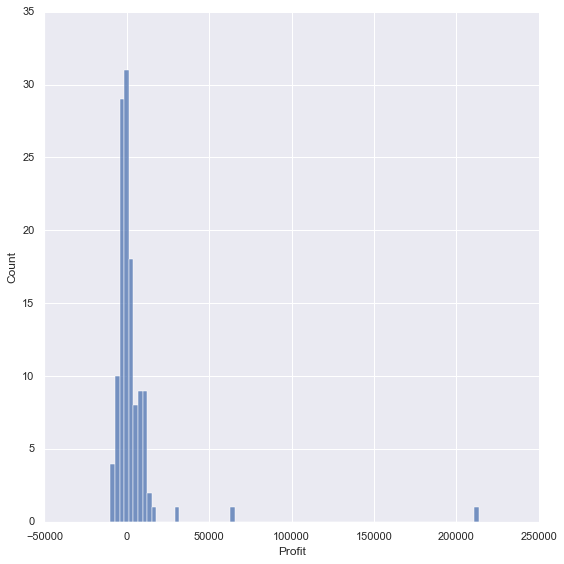

In [288]:
stock_df =stock_df.loc[stock_df['siteDay_CurDate']!=""]
sns.displot(stock_df,x='Profit',height=8)

In [289]:

testticker = yf.Ticker("SXTC")

In [294]:
hist = testticker.history(start='2021-01-01',end='2022-01-02')



In [295]:
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-12-31,1.380,1.392,1.296,1.316,464150,0,0.0
2021-01-04,1.336,1.628,1.324,1.568,2559925,0,0.0
2021-01-05,1.556,1.960,1.496,1.900,4251050,0,0.0
2021-01-06,1.768,1.816,1.600,1.640,2003975,0,0.0
2021-01-07,1.648,1.700,1.600,1.632,668600,0,0.0
...,...,...,...,...,...,...,...
2021-12-27,0.572,0.572,0.540,0.570,73900,0,0.0
2021-12-28,0.545,0.586,0.535,0.564,319900,0,0.0
2021-12-29,0.550,0.628,0.534,0.593,430600,0,0.0
